# Hu·∫•n luy·ªán m√¥ h√¨nh nh·∫≠n d·∫°ng d·∫•u thanh cho VSLR

Notebook n√†y th·ª±c hi·ªán hu·∫•n luy·ªán m√¥ h√¨nh LSTM v√† MLP ƒë·ªÉ nh·∫≠n d·∫°ng 5 d·∫•u thanh ti·∫øng Vi·ªát: huy·ªÅn, s·∫Øc, h·ªèi, ng√£, n·∫∑ng th√¥ng qua c√°c h√†nh ƒë·ªông tay.

## C√°c b∆∞·ªõc th·ª±c hi·ªán:
1. Import th∆∞ vi·ªán v√† kh·ªüi t·∫°o
2. Chu·∫©n b·ªã d·ªØ li·ªáu keypoints
3. X√¢y d·ª±ng m√¥ h√¨nh LSTM v√† MLP
4. Hu·∫•n luy·ªán c√°c m√¥ h√¨nh
5. ƒê√°nh gi√° v√† so s√°nh k·∫øt qu·∫£
6. L∆∞u m√¥ h√¨nh t·ªët nh·∫•t


## 1. Import th∆∞ vi·ªán v√† kh·ªüi t·∫°o


In [1]:
import os
import sys
import time
import json
import pickle
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Add parent directory to path for imports
sys.path.append(str(Path().resolve().parent.parent.parent))

# Thi·∫øt l·∫≠p matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


TensorFlow version: 2.9.0
NumPy version: 1.26.3


## 2. ƒê·ªãnh nghƒ©a DataProcessor v√† Models


In [2]:
class ToneDataProcessor:
    """Class x·ª≠ l√Ω d·ªØ li·ªáu d·∫•u thanh"""
    
    def __init__(self, data_dir: str):
        """
        Kh·ªüi t·∫°o ToneDataProcessor
        
        Args:
            data_dir (str): Th∆∞ m·ª•c d·ªØ li·ªáu
        """
        self.data_dir = Path(data_dir)
        self.keypoints_dir = self.data_dir / "keypoints"
        
        # C√°c l·ªõp d·∫•u thanh
        self.classes = ['hoi', 'huyen', 'nang', 'nga', 'sac']
        self.class_names = {
            'hoi': 'H·ªèi',
            'huyen': 'Huy·ªÅn', 
            'nang': 'N·∫∑ng',
            'nga': 'Ng√£',
            'sac': 'S·∫Øc'
        }
        
        # Label encoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.classes)
    
    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        T·∫£i d·ªØ li·ªáu t·ª´ th∆∞ m·ª•c keypoints
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: (X, y) - features v√† labels
        """
        X_list = []
        y_list = []
        
        print("Loading tone data...")
        
        for class_name in self.classes:
            class_dir = self.keypoints_dir / class_name
            if not class_dir.exists():
                print(f"Warning: Class directory {class_dir} not found")
                continue
            
            class_idx = self.label_encoder.transform([class_name])[0]
            npy_files = list(class_dir.glob("*.npy"))
            
            print(f"Loading {len(npy_files)} samples for class {class_name}")
            
            for npy_file in npy_files:
                try:
                    keypoints = np.load(npy_file)
                    
                    # Ki·ªÉm tra shape
                    if keypoints.shape == (30, 63):
                        X_list.append(keypoints)
                        y_list.append(class_idx)
                    else:
                        print(f"Warning: Invalid shape {keypoints.shape} in {npy_file}")
                
                except Exception as e:
                    print(f"Error loading {npy_file}: {e}")
        
        if not X_list:
            raise ValueError("No valid data found!")
        
        X = np.array(X_list)
        y = np.array(y_list)
        
        print(f"Loaded {len(X)} samples with shape {X.shape}")
        return X, y
    
    def preprocess_data(self, X: np.ndarray, y: np.ndarray, 
                       test_size: float = 0.2, random_state: int = 42) -> Tuple:
        """
        Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu
        
        Args:
            X (np.ndarray): Features
            y (np.ndarray): Labels
            test_size (float): T·ª∑ l·ªá test set
            random_state (int): Random seed
            
        Returns:
            Tuple: (X_train, X_test, y_train, y_test, y_train_cat, y_test_cat)
        """
        print("Preprocessing data...")
        
        # Chia train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # One-hot encoding
        y_train_cat = to_categorical(y_train, num_classes=len(self.classes))
        y_test_cat = to_categorical(y_test, num_classes=len(self.classes))
        
        print(f"Train set: {X_train.shape}, {y_train_cat.shape}")
        print(f"Test set: {X_test.shape}, {y_test_cat.shape}")
        
        return X_train, X_test, y_train, y_test, y_train_cat, y_test_cat


In [3]:
class ToneLSTMModel:
    """LSTM model cho nh·∫≠n d·∫°ng d·∫•u thanh"""
    
    def __init__(self, input_shape: Tuple[int, int], num_classes: int = 5):
        """
        Kh·ªüi t·∫°o ToneLSTMModel
        
        Args:
            input_shape (Tuple[int, int]): Shape ƒë·∫ßu v√†o (sequence_length, features)
            num_classes (int): S·ªë l·ªõp
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
    
    def create_model(self) -> Model:
        """T·∫°o m√¥ h√¨nh LSTM"""
        print("Creating LSTM model...")
        
        # Input layer
        inputs = Input(shape=self.input_shape, name='input_layer')
        
        # LSTM layers
        x = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
        x = BatchNormalization()(x)
        
        x = LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
        x = BatchNormalization()(x)
        
        # Dense layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Output layer
        outputs = Dense(self.num_classes, activation='softmax', name='output_layer')(x)
        
        # Create model
        self.model = Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model
    
    def get_model_summary(self):
        """In th√¥ng tin m√¥ h√¨nh"""
        if self.model is None:
            print("Model not created yet!")
            return
        
        self.model.summary()
        
        # T√≠nh s·ªë parameters
        total_params = self.model.count_params()
        print(f"\nTotal parameters: {total_params:,}")

class ToneMLPModel:
    """MLP model cho nh·∫≠n d·∫°ng d·∫•u thanh"""
    
    def __init__(self, input_shape: int, num_classes: int = 5):
        """
        Kh·ªüi t·∫°o ToneMLPModel
        
        Args:
            input_shape (int): S·ªë features ƒë·∫ßu v√†o (flattened)
            num_classes (int): S·ªë l·ªõp
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
    
    def create_model(self) -> Model:
        """T·∫°o m√¥ h√¨nh MLP"""
        print("Creating MLP model...")
        
        # Input layer
        inputs = Input(shape=(self.input_shape,), name='input_layer')
        
        # Dense layers
        x = Dense(512, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        
        # Output layer
        outputs = Dense(self.num_classes, activation='softmax', name='output_layer')(x)
        
        # Create model
        self.model = Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model


## 3. Thi·∫øt l·∫≠p tham s·ªë v√† chu·∫©n b·ªã d·ªØ li·ªáu


In [4]:
# Thi·∫øt l·∫≠p tham s·ªë
data_dir = "../../data/tones"
model_dir = "../../trained_models"
batch_size = 32
epochs = 100

# T·∫°o th∆∞ m·ª•c model
os.makedirs(model_dir, exist_ok=True)

print("=== TH√îNG TIN THAM S·ªê ===")
print(f"Data directory: {data_dir}")
print(f"Model directory: {model_dir}")
print(f"Batch size: {batch_size}")
print(f"Number of epochs: {epochs}")


=== TH√îNG TIN THAM S·ªê ===
Data directory: ../../data/tones
Model directory: ../../trained_models
Batch size: 32
Number of epochs: 100


In [5]:
# Kh·ªüi t·∫°o DataProcessor v√† t·∫£i d·ªØ li·ªáu
print("Initializing data processor...")
data_processor = ToneDataProcessor(data_dir)

# T·∫£i d·ªØ li·ªáu
X, y = data_processor.load_data()

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu
X_train, X_test, y_train, y_test, y_train_cat, y_test_cat = data_processor.preprocess_data(X, y)

# T·∫°o MLP data (flatten)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"\nLSTM input shape: {X_train.shape}")
print(f"MLP input shape: {X_train_flat.shape}")
print(f"Number of classes: {len(data_processor.classes)}")
print(f"Classes: {list(data_processor.class_names.values())}")


Initializing data processor...
Loading tone data...
Loading 80 samples for class hoi
Loading 80 samples for class huyen
Loading 80 samples for class nang
Loading 80 samples for class nga
Loading 80 samples for class sac
Loaded 400 samples with shape (400, 30, 63)
Preprocessing data...
Train set: (320, 30, 63), (320, 5)
Test set: (80, 30, 63), (80, 5)

LSTM input shape: (320, 30, 63)
MLP input shape: (320, 1890)
Number of classes: 5
Classes: ['H·ªèi', 'Huy·ªÅn', 'N·∫∑ng', 'Ng√£', 'S·∫Øc']


## 4. T·∫°o v√† hu·∫•n luy·ªán m√¥ h√¨nh LSTM


In [6]:
# T·∫°o m√¥ h√¨nh LSTM
print("="*50)
print("Training LSTM Model")
print("="*50)

lstm_model = ToneLSTMModel(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=len(data_processor.classes)
)
model = lstm_model.create_model()
lstm_model.get_model_summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'lstm_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("Starting LSTM training...")
start_time = time.time()

lstm_history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"LSTM training completed in {training_time:.2f} seconds")

# L∆∞u final model
model.save(os.path.join(model_dir, 'lstm_model_final.h5'))
print("LSTM model saved!")


Training LSTM Model
Creating LSTM model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 30, 63)]          0         
                                                                 
 lstm (LSTM)                 (None, 30, 128)           98304     
                                                                 
 batch_normalization (BatchN  (None, 30, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)    

## 5. T·∫°o v√† hu·∫•n luy·ªán m√¥ h√¨nh MLP


In [7]:
# T·∫°o m√¥ h√¨nh MLP
print("="*50)
print("Training MLP Model")
print("="*50)

mlp_model = ToneMLPModel(
    input_shape=X_train_flat.shape[1],
    num_classes=len(data_processor.classes)
)
model = mlp_model.create_model()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'mlp_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training
print("Starting MLP training...")
start_time = time.time()

mlp_history = model.fit(
    X_train_flat, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_flat, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"MLP training completed in {training_time:.2f} seconds")

# L∆∞u final model
model.save(os.path.join(model_dir, 'mlp_model_final.h5'))
print("MLP model saved!")


Training MLP Model
Creating MLP model...
Starting MLP training...
Epoch 1/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.5874 - accuracy: 0.8281
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to ../../trained_models\mlp_best.h5
10/10 [==============================] - 1s 30ms/step - loss: 0.4867 - accuracy: 0.8594 - val_loss: 2.8518 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 0.9861
Epoch 2: val_accuracy improved from 0.20000 to 0.25000, saving model to ../../trained_models\mlp_best.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0598 - accuracy: 0.9875 - val_loss: 3.0325 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.25000
10/10 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 2.798

## 6. ƒê√°nh gi√° v√† so s√°nh c√°c m√¥ h√¨nh


In [8]:
# ƒê√°nh gi√° c√°c m√¥ h√¨nh
print("="*50)
print("Evaluating Models")
print("="*50)

# ƒê√°nh gi√° LSTM
print("\nLSTM Model Evaluation:")
lstm_loss, lstm_acc = lstm_model.model.evaluate(
    X_test, y_test_cat, verbose=0
)
print(f"LSTM - Loss: {lstm_loss:.4f}, Accuracy: {lstm_acc:.4f}")

# Predictions LSTM
lstm_pred = lstm_model.model.predict(X_test)
lstm_pred_classes = np.argmax(lstm_pred, axis=1)

# Classification report LSTM
print("\nLSTM Classification Report:")
print(classification_report(
    y_test, lstm_pred_classes, 
    target_names=list(data_processor.class_names.values())
))

# ƒê√°nh gi√° MLP
print("\nMLP Model Evaluation:")
mlp_loss, mlp_acc = mlp_model.model.evaluate(
    X_test_flat, y_test_cat, verbose=0
)
print(f"MLP - Loss: {mlp_loss:.4f}, Accuracy: {mlp_acc:.4f}")

# Predictions MLP
mlp_pred = mlp_model.model.predict(X_test_flat)
mlp_pred_classes = np.argmax(mlp_pred, axis=1)

# Classification report MLP
print("\nMLP Classification Report:")
print(classification_report(
    y_test, mlp_pred_classes, 
    target_names=list(data_processor.class_names.values())
))


Evaluating Models

LSTM Model Evaluation:
LSTM - Loss: 0.0241, Accuracy: 1.0000
3/3 [==============================] - 0s 8ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

         H·ªèi       1.00      1.00      1.00        16
       Huy·ªÅn       1.00      1.00      1.00        16
        N·∫∑ng       1.00      1.00      1.00        16
         Ng√£       1.00      1.00      1.00        16
         S·∫Øc       1.00      1.00      1.00        16

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


MLP Model Evaluation:
MLP - Loss: 0.0363, Accuracy: 1.0000
3/3 [==============================] - 0s 0s/step

MLP Classification Report:
              precision    recall  f1-score   support

         H·ªèi       1.00      1.00      1.00        16
       Huy·ªÅn       1.00      1.00      1.00        16
        N·∫∑ng       1.00      1.00  

## 7. V·∫Ω bi·ªÉu ƒë·ªì Confusion Matrix


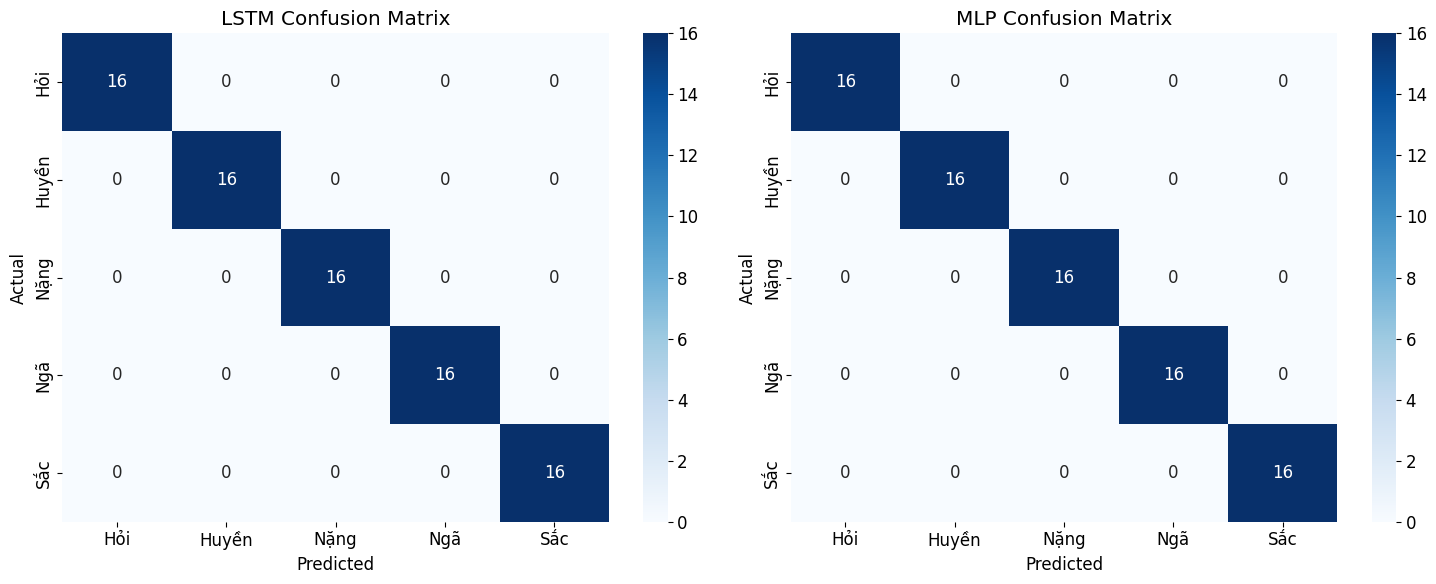

In [9]:
# V·∫Ω Confusion Matrix cho c·∫£ hai m√¥ h√¨nh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

class_names = list(data_processor.class_names.values())

# LSTM Confusion Matrix
cm_lstm = confusion_matrix(y_test, lstm_pred_classes)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=class_names, yticklabels=class_names)
ax1.set_title('LSTM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, mlp_pred_classes)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=ax2,
           xticklabels=class_names, yticklabels=class_names)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'tone_confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()


## 8. V·∫Ω bi·ªÉu ƒë·ªì Training History


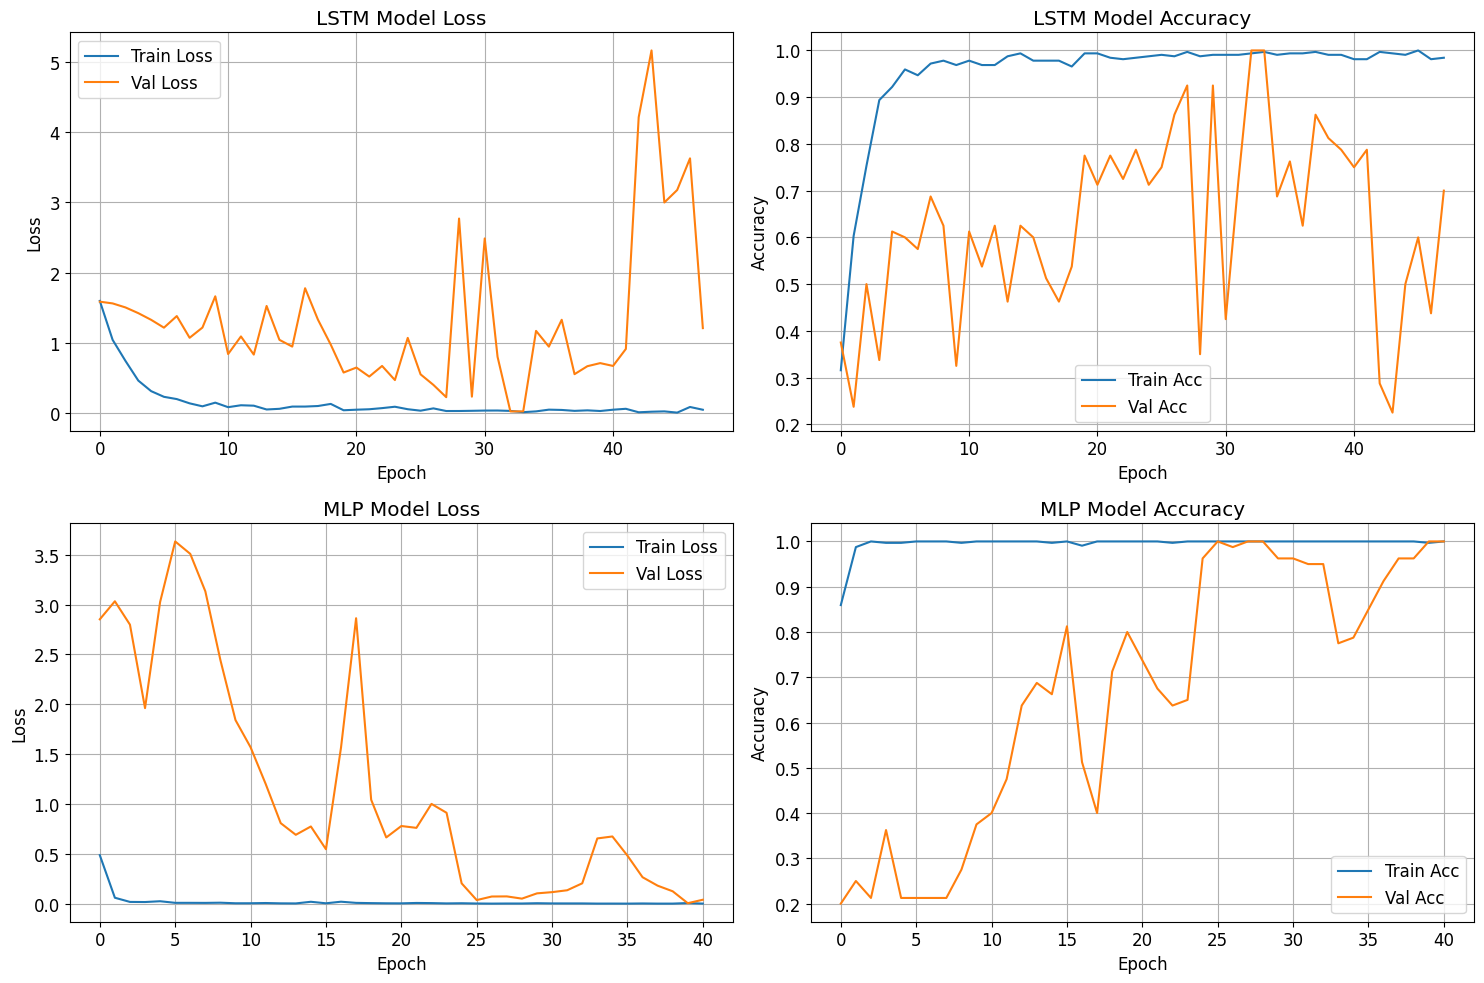

In [10]:
# V·∫Ω bi·ªÉu ƒë·ªì training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# LSTM plots
# Loss
axes[0, 0].plot(lstm_history.history['loss'], label='Train Loss')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('LSTM Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(lstm_history.history['accuracy'], label='Train Acc')
axes[0, 1].plot(lstm_history.history['val_accuracy'], label='Val Acc')
axes[0, 1].set_title('LSTM Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# MLP plots
# Loss
axes[1, 0].plot(mlp_history.history['loss'], label='Train Loss')
axes[1, 0].plot(mlp_history.history['val_loss'], label='Val Loss')
axes[1, 0].set_title('MLP Model Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy
axes[1, 1].plot(mlp_history.history['accuracy'], label='Train Acc')
axes[1, 1].plot(mlp_history.history['val_accuracy'], label='Val Acc')
axes[1, 1].set_title('MLP Model Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'tone_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()


## 9. So s√°nh hi·ªáu su·∫•t v√† l∆∞u m√¥ h√¨nh t·ªët nh·∫•t


=== SO S√ÅNH HI·ªÜU SU·∫§T M√î H√åNH ===
LSTM - Test Accuracy: 1.0000, Test Loss: 0.0241
MLP  - Test Accuracy: 1.0000, Test Loss: 0.0363

üèÜ M√¥ h√¨nh t·ªët nh·∫•t: MLP (Accuracy: 1.0000)


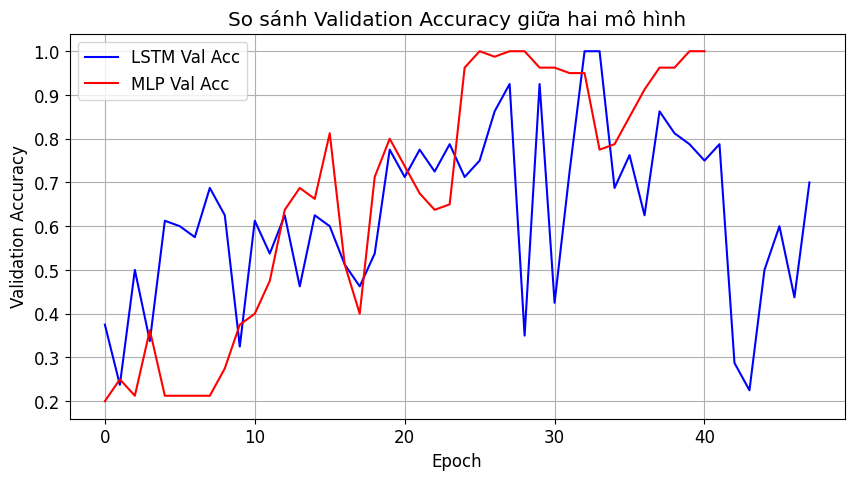

In [11]:
# So s√°nh hi·ªáu su·∫•t hai m√¥ h√¨nh
print("=== SO S√ÅNH HI·ªÜU SU·∫§T M√î H√åNH ===")
print(f"LSTM - Test Accuracy: {lstm_acc:.4f}, Test Loss: {lstm_loss:.4f}")
print(f"MLP  - Test Accuracy: {mlp_acc:.4f}, Test Loss: {mlp_loss:.4f}")

# X√°c ƒë·ªãnh m√¥ h√¨nh t·ªët nh·∫•t
best_model_name = 'LSTM' if lstm_acc > mlp_acc else 'MLP'
best_accuracy = max(lstm_acc, mlp_acc)

print(f"\nüèÜ M√¥ h√¨nh t·ªët nh·∫•t: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh accuracy
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc', color='blue')
plt.plot(mlp_history.history['val_accuracy'], label='MLP Val Acc', color='red')
plt.title('So s√°nh Validation Accuracy gi·ªØa hai m√¥ h√¨nh')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'tone_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


## 10. L∆∞u label encoder v√† t√≥m t·∫Øt k·∫øt qu·∫£


In [12]:
# L∆∞u label encoder
encoder_path = os.path.join(model_dir, 'lstm_model_label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(data_processor.label_encoder, f)
print(f"Label encoder saved to {encoder_path}")

print("\n=== T√ìM T·∫ÆT K·∫æT QU·∫¢ HU·∫§N LUY·ªÜN M√î H√åNH D·∫§U THANH ===")
print(f"\nüìä Th·ªëng k√™ d·ªØ li·ªáu:")
print(f"  - T·ªïng s·ªë m·∫´u: {len(X)}")
print(f"  - S·ªë l·ªõp: {len(data_processor.classes)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Classes: {list(data_processor.class_names.values())}")

print(f"\nü§ñ K·∫øt qu·∫£ m√¥ h√¨nh:")
print(f"  - LSTM Accuracy: {lstm_acc:.4f}")
print(f"  - MLP Accuracy: {mlp_acc:.4f}")
print(f"  - M√¥ h√¨nh t·ªët nh·∫•t: {best_model_name}")

print(f"\nüíæ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i:")
print(f"  - LSTM best: {os.path.join(model_dir, 'lstm_best.h5')}")
print(f"  - LSTM final: {os.path.join(model_dir, 'lstm_model_final.h5')}")
print(f"  - MLP best: {os.path.join(model_dir, 'mlp_best.h5')}")
print(f"  - MLP final: {os.path.join(model_dir, 'mlp_model_final.h5')}")
print(f"  - Label encoder: {encoder_path}")
print(f"  - Confusion matrices: {os.path.join(model_dir, 'tone_confusion_matrices.png')}")
print(f"  - Training history: {os.path.join(model_dir, 'tone_training_history.png')}")
print(f"  - Model comparison: {os.path.join(model_dir, 'tone_model_comparison.png')}")

print(f"\nüéØ B∆∞·ªõc ti·∫øp theo:")
print(f"  - S·ª≠ d·ª•ng m√¥ h√¨nh t·ªët nh·∫•t ({best_model_name}) trong ·ª©ng d·ª•ng nh·∫≠n d·∫°ng d·∫•u thanh")
print(f"  - Ho·∫∑c ti·∫øp t·ª•c fine-tuning v·ªõi d·ªØ li·ªáu m·ªõi")


Label encoder saved to ../../trained_models\lstm_model_label_encoder.pkl

=== T√ìM T·∫ÆT K·∫æT QU·∫¢ HU·∫§N LUY·ªÜN M√î H√åNH D·∫§U THANH ===

üìä Th·ªëng k√™ d·ªØ li·ªáu:
  - T·ªïng s·ªë m·∫´u: 400
  - S·ªë l·ªõp: 5
  - Training samples: 320
  - Test samples: 80
  - Classes: ['H·ªèi', 'Huy·ªÅn', 'N·∫∑ng', 'Ng√£', 'S·∫Øc']

ü§ñ K·∫øt qu·∫£ m√¥ h√¨nh:
  - LSTM Accuracy: 1.0000
  - MLP Accuracy: 1.0000
  - M√¥ h√¨nh t·ªët nh·∫•t: MLP

üíæ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i:
  - LSTM best: ../../trained_models\lstm_best.h5
  - LSTM final: ../../trained_models\lstm_model_final.h5
  - MLP best: ../../trained_models\mlp_best.h5
  - MLP final: ../../trained_models\mlp_model_final.h5
  - Label encoder: ../../trained_models\lstm_model_label_encoder.pkl
  - Confusion matrices: ../../trained_models\tone_confusion_matrices.png
  - Training history: ../../trained_models\tone_training_history.png
  - Model comparison: ../../trained_models\tone_model_comparison.png

üéØ B∆∞·ªõc ti·∫øp theo:
  - S